# Detecting pneumonia using chest x-rays

### To Do List

#### Research:
* CNNs
    * How do they work?
    * Idea of transfer learning
* Unique CNN implementations: AlexNet, CapsNet, GNN
    * What is unique about each of these implementations?
    
#### Implementation:
* Basic CNNs (PyTorch, tensorflow, keras)
* Transfer learning example
* Unique CNN implementations
* Understanding what the CNN found important (https://github.com/albermax/innvestigate)

#### Blog:
* Choosing a service (Medium, ...)

## Research

#### Convolutional Neural Networks (CNNs)

CNNs are used for classifaction and computer vision. They are made up of three types of layers: convolutional, pooling, and fully-connected (FC). The first layer is a convolutional layer, and the last layer is the only fully-connected layer. The layers in between may be a mix of convolutional and pooling layers [1]. 

##### Convolutional Layers [1]
Convolutiuonal layers have an input, a filter (AKA kernel or feature detector), and a feature map. The feature detector is typically a 2D array of weights, which is applied to a subsection of the input. The dot product between this subsection and the kernel is then calculated. The filter then shifts by a stride, and performs the dot product operation once more, repeating this process until it has covered the entire input. The resulting array of outputs is called the feature map.

Some hyperparameters that can be adjusted in the convolutional layer are number of filters, stride, and zero padding. Number of filters affects the depth of the feature map (e.g. three filters results in a depth three feature map). Stride is the number of pixels the kernel moves after each dot product calculation. Zero padding refers to the amount of padding added to an input (eg. an image) to ensure that the filter fits the image.

After each convolution, the CNN applies a ReLU to introduce nonlinearities into the network, ensuring that the model is a universal approximator.

##### Pooling Layers [1]
Similar to a convolutional layer, except the filter does not use weights. Instead it implements a specific type of pooling: max pooling or average pooling. Max pooling is when the filter selects the pixel of maximum value to send to the output array. Average pooling is when the filter calculates the average value in the receptive field (the values that the filter can see).

More information is lost in pooling layers, but they "reduce complexity, improve efficiency, and limit risk of overfitting".

##### Fully-Connected Layer [1]
Usually uses a softmax activation function to make the final classification prediction.

# Basic CNN Implementation

In [25]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 # https://pypi.org/project/opencv-python/
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import innvestigate
import innvestigate.utils
import os

#### Load Data [2]

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(e)
                
    return np.array(data)

In [ ]:
train = get_training_data('./chest_xray/train')
test = get_training_data('./chest_xray/test')
val = get_training_data('./chest_xray/val')

#### EDA (Exploratory Data Analysis) [2]

In [ ]:
fig = plt.figure(figsize=(10,5))
a1 = fig.add_subplot(1,2,1)
plt.imshow(train[0][0], cmap='gray')
a1.set_title(labels[train[0][1]])
a1.set_xticks([])
a1.set_yticks([])

a2 = fig.add_subplot(1, 2, 2)
plt.imshow(train[-1][0], cmap='gray')
a2.set_title(labels[train[-1][1]])
a2.set_xticks([])
a2.set_yticks([])

plt.show()

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('Pneumonia')
    else:
        l.append('Normal')
        
sns.set_style('darkgrid')
sns.countplot(x=l)

plt.show()

#### Basic CNN Implementation [2]

In [ ]:
# Preprocessing

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalization

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
# Resizing Data For CNN

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
# Data Augmentation (Grayscales, Horizontal Flips, Vertical Flips, Random Crops, Color Jitters, Translations, Rotations, ...)
# Slightly alter the training data to increase the number of training examples and prevent overfitting

datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

datagen.fit(x_train)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/

model = Sequential()
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding='same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [ ]:
model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=12, 
          validation_data=datagen.flow(x_val, y_val), callbacks=[learning_rate_reduction])

model.save('./models/keras-cnn')

In [ ]:
model = load_model('./models/keras-cnn')

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

# Transfer Learning with ResNet [4]

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

In [40]:
dataset = ImageFolder('./chest_xray/train',
                         transform=tt.Compose([tt.Resize(255),
                                               tt.CenterCrop(224),
                                               tt.RandomHorizontalFlip(),
                                               tt.RandomRotation(10),
                                               tt.RandomGrayscale(),
                                               tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                               tt.ToTensor()
                                              ]))

In [41]:
random_seed = 42
torch.manual_seed(random_seed)

In [42]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [43]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

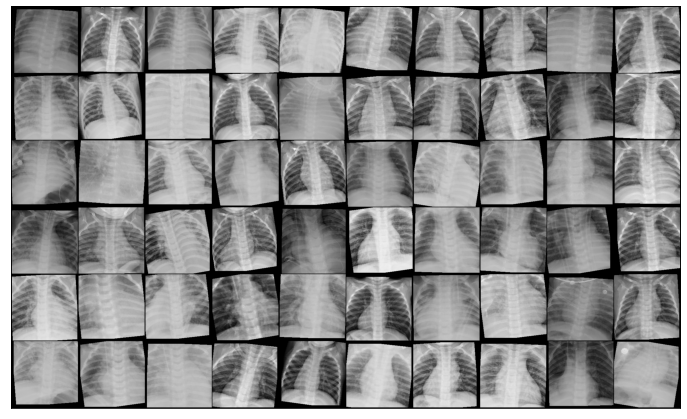

In [44]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[0:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [46]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [47]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [48]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        return len(self.dl)

In [49]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds)), preds

In [50]:
class PneumoniaModelBase(nn.Module):
    
    def training_step(self, batch, weight):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels, weight=weight)
        acc, preds = accuracy(out, labels)
        
        return {'train_loss': loss, 'train_acc': acc}
    
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc,preds = accuracy(out, labels)
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
        
    def test_prediction(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}   

In [51]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\willi_jnl/.cache\torch\checkpoints\resnet50-19c8e357.pth
100%|███████████████████████████████████████████████████████████████| 102502400/102502400 [00:17<00:00, 5768976.69it/s]


In [52]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super.__init__()
        self.network = models.resnet50(pretrained=True)
        for param in self.network.fc.parameters():
            param.require_grad = False
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 2)
        
    def forward(self, xb):
        return self.network(xb)

In [53]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def fit(epochs, lr, model, train_loader, val_loader, weight, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = {}
    
    optimizer = opt_func(model.parameters(), lr)
    best_loss = 1
    for epoch in range(epochs):
        
        model.train()
        train_outputs = []
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']
            train_outputs.append(outputs)
            
            train_results = model.train_epoch_end(train_outputs)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        val_results = evaluate(model, val_loader)
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            
        model.epoch_end(epoch, train_results, val_results)
        
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
                
        model.load_state_dict(best_model_wts)
        
        return history, optimizer, best_loss

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## References

[1] https://www.ibm.com/cloud/learn/convolutional-neural-networks

[2] https://www.kaggle.com/madz2000/pneumonia-detection-using-cnn-92-6-accuracy

[3] https://data.mendeley.com/datasets/rscbjbr9sj/2 (THIS IS THE DATASET)

[4] https://www.kaggle.com/teyang/pneumonia-detection-resnets-pytorch